# RKDE (Robust Kernel Density Estimation)

## Generating  the data set

In [8]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.style as style

style.use('fivethirtyeight')
matplotlib.rcParams['figure.figsize'] = (20,10)
# Define the number of points
n_samples = 200

mu1, sigma1 = 0,1 # mean and variance
mu2, sigma2 = 15,1

def pdf(loc,variance,observation):
    '''Giving the Probability Density Function

    Parameters
    ----------
        loc (Int): Mean of the distribution ; where the peak of the bell exists
        variance(Int) : variance
        sample (Array) : the distribution

    Returns
    -------
        ndrray: Gaussian distribution
    '''
    # A normal continuous random variable.
    s1 = 1/(np.sqrt(2*np.pi*variance))
    s2 = np.exp(-(np.square(observation - loc)/(2*variance)))
    return s1 * s2 

def generate_outliers(type_distribution='uniform', sigma=[], ):
    
    if type_distribution == 'uniform':
        outliers1 = np.random.uniform(5.5,6,10)
        outliers2 = np.random.uniform(9,10,10)
    elif type_distribution == 'exponential not yet':
        outliers1 = np.random.exponential(5.5,6,10)
        outliers2 = np.random.exponential(9,10,10)
    elif type_distribution == 'laplacian not yet':
        outliers1 = np.random.laplace(5.5,6,10)
        outliers2 = np.random.laplace(9,10,10)
    elif type_distribution == 'gamma':
        outliers1 = np.random.gamma(5.7,sigma[0],10)
        outliers2 = np.random.gamma(9.5,sigma[1],10)
    elif type_distribution == 'weibull':
        outliers1 = np.random.weibull(5.7,10)
        outliers2 = np.random.weibull(9.5,10)
        print(outliers1)
 
    return outliers1, outliers2

## should generate the main dataset from gaussian/ gamma / weibull / T  distribution
X_no_outliers = np.random.normal(0,1,n_samples)   #gaussain distributin
#x1 = np.random.normal(mu1,np.sqrt(sigma1),n_samples)
#x2 = np.random.normal(mu2,np.sqrt(sigma2),n_samples)
#X = np.array(list(x1) + list(x2))

# Generating outliers (uniform distribution)
outliers = np.random.uniform(4,6,20)
type_dist = "uniform"
#outliers1, outliers2 = generate_outliers(type_dist, [sigma1,sigma2] )
#outliers = np.append(outliers1, outliers2)

# Adding outliers
X = np.append(X_no_outliers, outliers)
#np.random.shuffle(X)
print("Dataset Shape: ", X.shape)
n_samples_final = X.shape[0]
# STANDARD DEVIATION
std = np.std(X)
# WINDOWS SIZE
#windows = (1/np.sqrt(n_samples_final)*20)
windows = .5 * n_samples_final**(-1/5) * std

Dataset Shape:  (220,)


## KDE functions

In [9]:
def kernel_function(obs,givenData,h,d=1):
    """  Kernel Function

    Parameters
    ----------
        obs (Int): Observation data
        h (Int): variance of the distribution
        d (Int, optional): dimension
        givenData (Int): Gaussian value
    
    Returns
    -------
        Int: kernel value   
    """
    ## if type== 'gaussian':
    result = (h**2 * 2*np.pi)**(-d/2) *np.exp((-1/2)* ((obs - givenData)/h)**2)
    """ elif type == 'exponential':
        result = np.exp(- (obs - givenData / (2* h**2)))
    elif type == 'laplacian':
        result = np.exp(- (obs - givenData / h)) """
    return result

def kernel_density_function(obs_data,givenData,h=.1,d=1):
    '''Kernel Density Function
    Parameters
    ----------
        obs_data (Array): Observation data  
        h (Int): windows size
        d (Int, optional): dimension
        givenData (Array): Gaussian values

    Returns
    -------
      Array: new data after applying kdf
    '''
    final_result = []
    # Size of the gaussian data
    size = len(givenData)
    for obs in obs_data:
        k_result = 0
        for g in givenData:
            k_result +=  (1/size) * kernel_function(obs,g,h)
        final_result.append(k_result)
    return final_result

def kernel_density_function_for_rkde(obs_data,givenData,weights, h=.1,d=1):
    '''Kernel Density Function
    Parameters
    ----------
        obs_data (Array): Observation data  
        h (Int): windows size

        d (Int, optional): dimension
        givenData (Array): Gaussian values

    Returns
    -------
      Array: new data after applying kdf
    '''
    final_result = []
    #weights = np.array(weights)
    #weights = np.array(weights)
    # Size of the gaussian data
    size = len(givenData)
    for obs in obs_data:
        k_result = 0
        for index,g in enumerate(givenData):
            #print(index)
            k_result +=  weights[index] * kernel_function(obs,g,h)
        final_result.append(k_result)
    return final_result 
# WINDOWS SIZE
windows = (1/np.sqrt(n_samples_final)*20)

In [10]:
from collections import Counter

def search_weight(X):
    count_weights = Counter(X)
    total = sum(count_weights.values())
    w_0 = [(count_weights[w] / total) for w in X]
    #print(count_weights)
    return w_0

def operand_2_func(index,weights,X,size_dist,windows):
    '''Generate operand 2

    Parameters
    ----------
        weights (array): the weights  
        X (array): the distribution
        windows (int): Windows size

    Returns
    -------
      int: operand 2
    '''
    #result = []
    result = 0
    for j in range(size_dist):
       #result.append(-2*weights[int(X[j])]*kernel_function(X[index],X[j],windows))
       result += weights[int(X[j])]*kernel_function(X[index],X[j],windows)
    result *= -2   
       #print(result)
    return result

def operand_3_func(weights,X, size_dist,windows):

  '''Generate operand 3

    Parameters
    ----------
        weights (array): the weights  
        X (array): the distribution
        windows (int): Windows size
    Returns
    ----------
      int: operand 3
    '''
  #final_result = []
  final_result = 0
  for i in range(size_dist):
    result = 0
    for j in range(size_dist):
      result += weights[int(X[i])]*weights[int(X[j])]*kernel_function(X[i],X[j],windows)
    #final_result.append(result)
    final_result += result
  return final_result

def derivative_huber_loss_func(value,alpha):
    #alpha = .0022
    #print(value)
    if value < -alpha:
        return -alpha
    elif -alpha <= value and value <= alpha:
        return value
    else:
        return alpha
def huber_loss_func(value,alpha):
    #alpha = .0022
    #print(value)
    value = np.abs(value)
    if value <= alpha:
        return value**2 / 2
    else:
        return alpha*value - (alpha**2 / 2)

def derivative_humpel_func(value,a,b,c):

  if 0 <= value and value < a:
    return value
  elif a <= value and value < b:
    return a
  elif b <= value and value < c:
    #print("{} {} {} {}".format(a, b, c, value))
    return a*(value-c) / (b-c)
  else:
    return 0

def humpel_func(value, a, b, c):
  if 0 <= value and value < a:
    return (value**2) / 2
  elif a <= value and value < b:
    return a * value - ((a**2) / 2)
  elif b <= value and value < c:
    return ((a *(value - c)**2) / 2*(b-c)) + ((a*(b+c-a)) / 2)
  else:
    return a * (b + c - a) / 2

def find_parameters(data):
  data = np.sort(data)
  median = np.median(data)
  percentile_75 = np.percentile(data,75)
  percentile_85 = np.percentile(data,85)
  return median, percentile_75, percentile_85


    
def update_weights(value, a, b=0, c=0):
    #print("Huber loss")
    return derivative_humpel_func(value,  a, b, c) / value
    #return derivative_huber_loss_func(value, a)

#Step 4 : Normalize the updated weights
def normalize_weight(updated_weights,sum_weights):
    '''Normalize weight

    Parameters
    ----------
        updated_weights (int): the weights  
        sum_weights (array): summation of the initial weight

    Returns
    -------
      int:  normalized weight
    '''
    return updated_weights / sum_weights
    
#Step 5 : If the algorithm converges
def convergence(w_0,normalized_weights):
    """ powered_w_0 = [x**2 for x in w_0]
    powered_normalized_weights = [x**2 for x in normalized_weights]
    convergence = (np.dot(w_0,normalized_weights)) / (np.sqrt(sum(powered_w_0)) * np.sqrt(sum(powered_normalized_weights))) """
    power_difference = np.power(np.subtract(w_0,normalized_weights),2)
    convergence = np.sqrt(sum(power_difference))
    return convergence

In [11]:
w_0 = search_weight(X)
print("100 First weight of the distribution\n")
print(w_0[:10])
print("\nWeights of the outliers")
print(w_0[:10])
print(sum(w_0))

100 First weight of the distribution

[0.004545454545454545, 0.004545454545454545, 0.004545454545454545, 0.004545454545454545, 0.004545454545454545, 0.004545454545454545, 0.004545454545454545, 0.004545454545454545, 0.004545454545454545, 0.004545454545454545]

Weights of the outliers
[0.004545454545454545, 0.004545454545454545, 0.004545454545454545, 0.004545454545454545, 0.004545454545454545, 0.004545454545454545, 0.004545454545454545, 0.004545454545454545, 0.004545454545454545, 0.004545454545454545]
0.9999999999999958


## Applying the process 

In [16]:
def process(X, w_0, windows, k=1, alpha=10**(-8),prev_updated_weights = []):
    #new_weights = []
    updated_weights = []
    humpel_results = []
    huber_results = []
    step2_result = []
    length = len(X)
    operand_3 = operand_3_func(w_0,X,length,windows)
    for index in range(length):
        ## Step 2
        operand_1 = kernel_function(X[index],X[index],windows)
        operand_2 = operand_2_func(index,w_0,X,length,windows)
        
        result = np.sqrt(operand_1 + operand_2 + operand_3)
        step2_result.append(result) 
    ## Step 3 
        # find out the different parameters 
        a, b, c = find_parameters(step2_result)
    for value in step2_result:
        ### FOR HUMPEL FUNCTION
        updated_weights.append(update_weights(value,a, b, c))
        humpel_results.append(humpel_func(value,a, b, c))
        ### FOR HUBER LOSS FUNCTION
        """ huber_results.append(huber_loss_func(value,alpha))
        updated_weights.append(update_weights(value,alpha)) """

    ### FOR HUMPEL FUNCTION
    summation_result = sum(humpel_results)
    ### FOR HUBER LOSS FUNCTION
    #summation_result = sum(huber_results)
    ## Step 3
    #print(step2_result)
    """ for value in step2_result:
        updated_weights.append(update_weights(value)) """
    
    #print("Summation of weights after updating {}".format(sum(updated_weights)))
    #print(updated_weights)
    ## Step 4
    normalized_weights = [normalize_weight(weight,sum(updated_weights)) for weight in updated_weights]
    """ print(normalized_weights[:10])
    print(sum(normalized_weights)) """
    ## Step 5
    #print("\n")
    #print(normalized_weights[:100])
    """ convergence_val = convergence(w_0,normalized_weights)
    sum_updated_outliers = sum(updated_weights[-20:])
    sum_normalized_outliers = sum(normalized_weights[-20:]) 
    print("Iteration: {}".format(k))
    print("Summation of outliers: {}".format(sum_updated_outliers))
    print("Summation of normalized outliers: {}".format(sum_normalized_outliers))"""
    #print("Status (decreasing ? ) : {}".format((False,True)[sum_outliers>sum_normalized_outliers]))
    #convergence_val = ((sum(humpel_results) - prev_updated_weights)/prev_updated_weights, sum(humpel_results))[k==1]
    convergence_val = ((summation_result - prev_updated_weights)/prev_updated_weights, summation_result)[k==1]
    print("Convergence")
    print(convergence_val)
    #print(normalized_weights)
    #iterations_humpel[k] = sum(humpel_results)

    """ diff = (sum(updated_weights) - sum(prev_updated_weights), None)[prev_updated_weights == []]
    print("Difference = {}".format(diff))
    print("\n") """
    ##if(prev_updated_weights == [] or (diff != None and diff > alpha)  ):
    if (np.round(convergence_val,3) > alpha):
        
        # pass the actual updated weights => prev_updated_weights
        #prev_updated_weights = updated_weights
        prev_updated_weights = summation_result
        """ print(k)
        print(w_0[10:-10]) """
        w_0 = normalized_weights
        #print("\nNew Weights Outliers")
        #print(w_0[:-50])
        k = k + 1
        """ if k==101 :
            return """
        process(X, w_0, windows,k,prev_updated_weights=prev_updated_weights)
    else:
        """ print("INTERATIONS AND NORMALIZED WEIGHT")
        print(iterations) """
        n_samples_final = X.shape[0]
        bins = np.linspace(np.min(X),np.max(X),n_samples_final)
        # Calculation of the KDE
        X_kde = kernel_density_function(bins,X,windows)
        #new_X = np.random.choice(X,n_samples_final,p=normalized_weights)
        # Calculation of the RKDE with the new weights
        X_rkde = kernel_density_function_for_rkde(bins,X,normalized_weights,windows)
        ##### PLOTING ##########
        plt.xlabel("$x$")
        plt.ylabel("pdf")
        plt.title("With {} distribution".format(type_dist))
        plt.scatter(X,[.005] * len(X), color='navy', s=30, marker=2, label="Train Data qith no outliers")
        #plt.scatter(outliers,[.005] * len(outliers), color='red', s=20, marker='x', label="Outliers")

        plt.plot(bins, .5 * pdf(mu1,sigma1,bins)+ .5 * pdf(mu2,sigma2,bins), color='black', label="True")
        #plt.plot(bins, pdf(mu2,sigma2,bins), color='black')

        plt.plot(bins, X_kde, color='blue', label="KDE", dashes=[6,2])
        plt.plot(bins, X_rkde, color='red', label="RKDE", dashes=[6,5])
        plt.legend()
        plt.show()
           

""" for i in range(len(X)):
    new_weights.append(process(i,X,w_0,windows))"""


#print(sum(weights[-20:]))
#print("\n")
#print(sum(new_weights[-20:]))

' for i in range(len(X)):\n    new_weights.append(process(i,X,w_0,windows))'

Convergence
9.990301941825216
Convergence
0.001705774752358963
Convergence
-0.003868538958524882


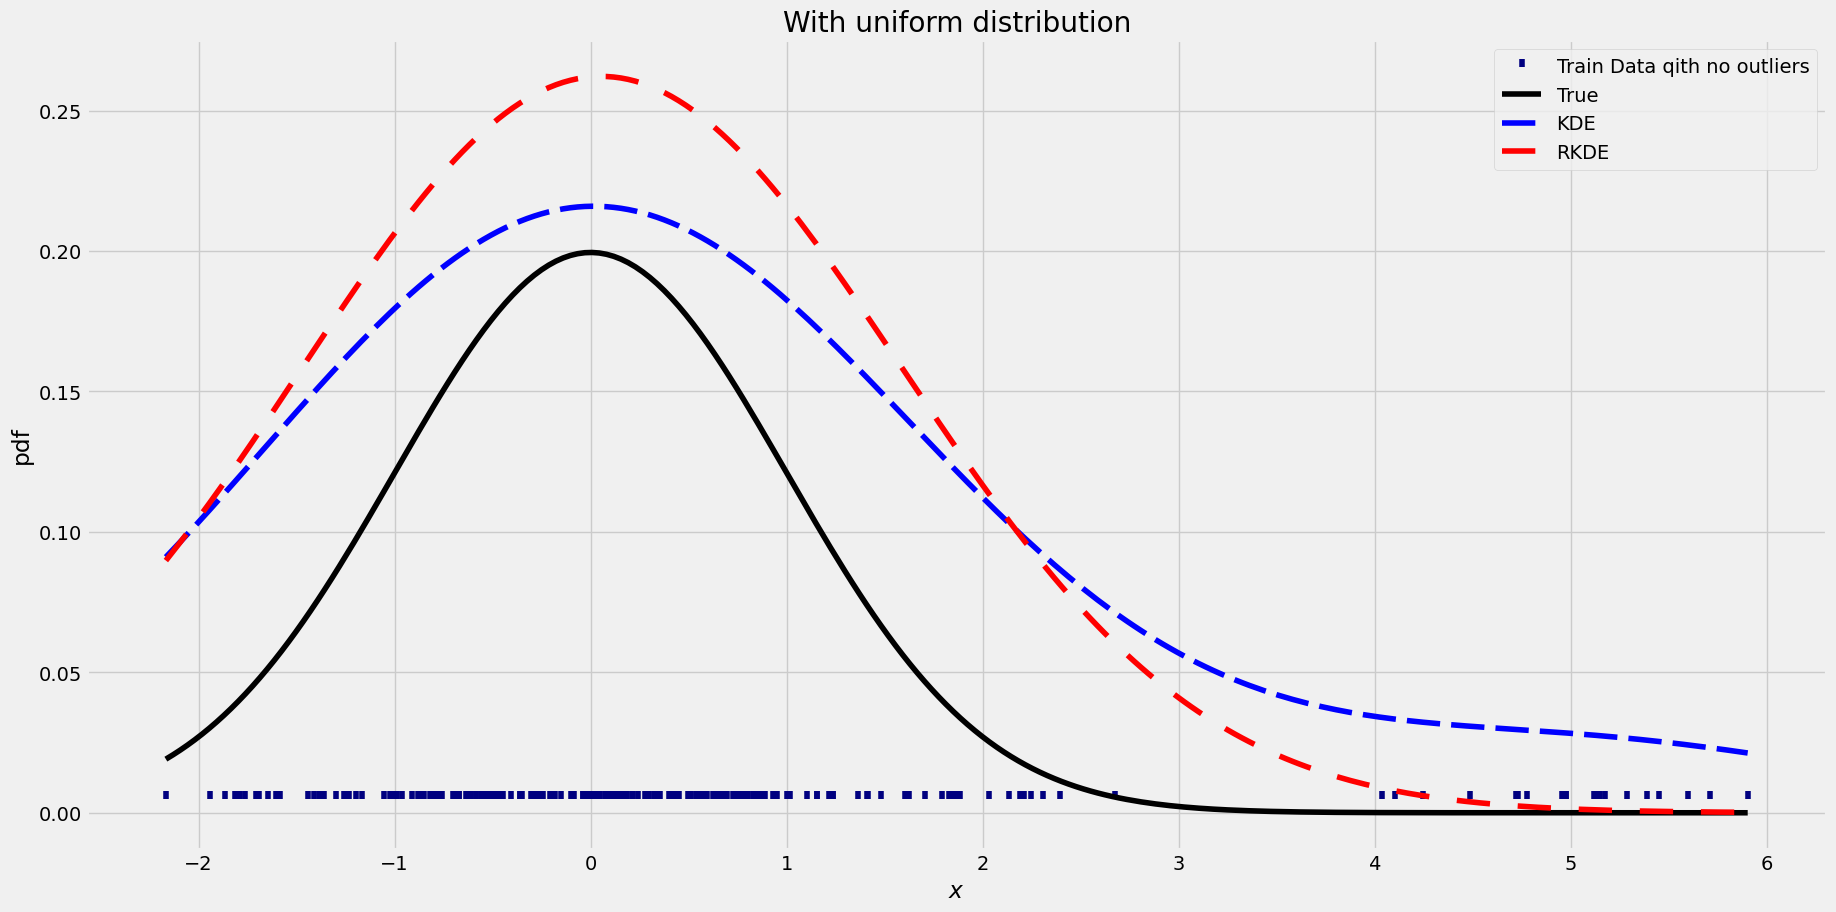

In [17]:
record_weights = process(X, w_0, windows)

In [15]:
for i in range(1,len(record_weights)+1):
    print(record_weights[i][-20:])
    print("SUMMATION : {}".format(sum(record_weights[i][-20:])))
    print("\n")

TypeError: object of type 'NoneType' has no len()

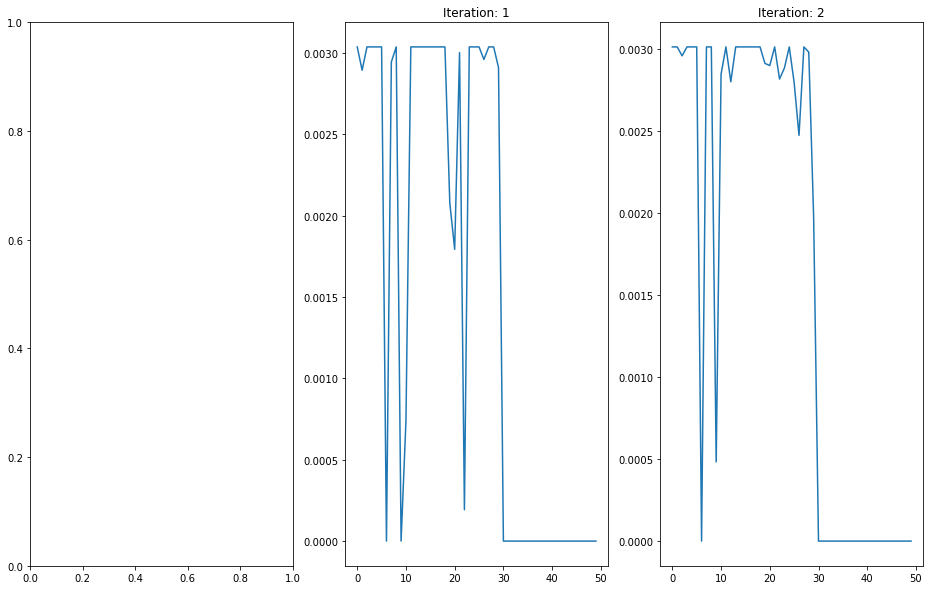

In [ ]:
new_outliers = []

len(record_weights)
fig, ax  = plt.subplots(ncols=3,figsize=(16,10))
for i in range(1,3):
    x = range(50)
    y = record_weights[i][-50:]
    ax[i].set_title("Iteration: {}".format(i))
    ax[i].plot(x,y)

plt.show()

In [ ]:
print(record_weights[2][-50:][0])

0.003013053664876186


In [ ]:
print(record_weights[3][-50:])

[0.00301211679129973, 0.00301211679129973, 0.00301211679129973, 0.00301211679129973, 0.00301211679129973, 0.00301211679129973, 0.00020160797322604963, 0.00301211679129973, 0.00301211679129973, 0.00042695322602751923, 0.0028113813945097967, 0.00301211679129973, 0.00301211679129973, 0.00301211679129973, 0.00301211679129973, 0.00301211679129973, 0.00301211679129973, 0.00301211679129973, 0.00301211679129973, 0.0029111876478110726, 0.0028898002916630753, 0.00301211679129973, 0.002771161417314611, 0.00301211679129973, 0.00301211679129973, 0.00301211679129973, 0.00301211679129973, 0.00301211679129973, 0.00301211679129973, 0.00301211679129973, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
